## Backtesting Moving Average Crossover Strategy 

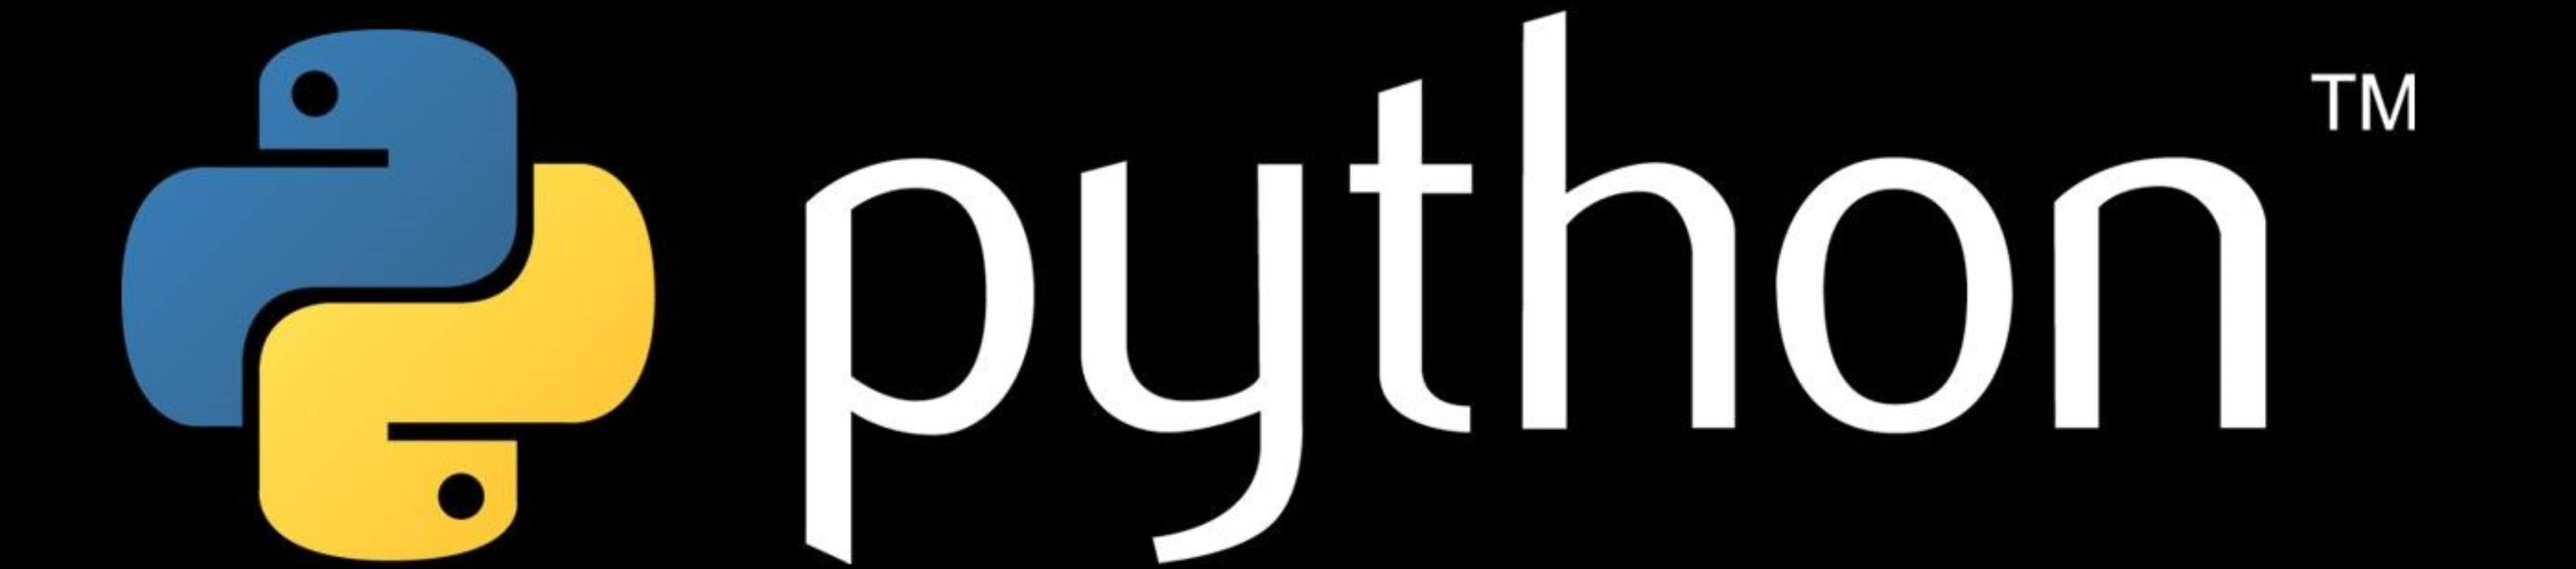

#### Hemant Thapa

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
from tabulate import tabulate

In [3]:
# List of tickers 
# ftse 100 -> Share index of the 100 companies listed on the London Stock Exchange with the highest market capitalisation.

# ftse 250 -> The FTSE 250 is a capitalization-weighted index consisting of the 101st to the 350th largest companies 
# listed on the London Stock Exchange (LSE) by market capitalization.

# ftse 350 -> The FTSE 350 FTLC Index, also known as the FTSE 350 Low Carbon Index, is an index designed to track the performance of companies
# listed on the London Stock Exchange (LSE) with relatively low carbon emissions. 
tickers = ['^FTSE', '^FTMC', '^FTLC']
print(tickers)

['^FTSE', '^FTMC', '^FTLC']


In [4]:
#historical data
historical_data = {}
#data mining
for i in tickers:
    historical_data[i] = yf.download(i, period='20Y')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


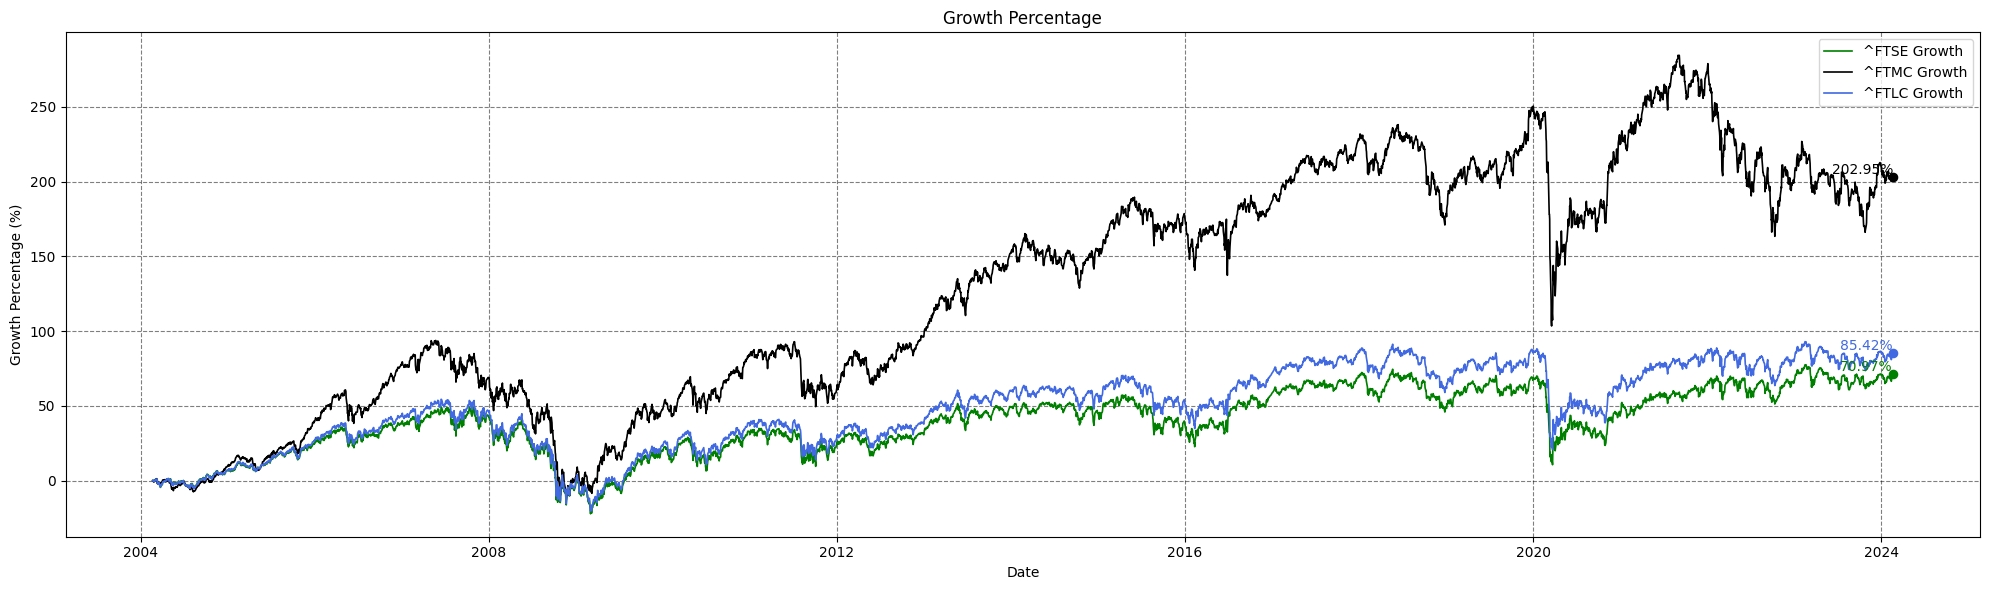

In [5]:
#comparing growth
plt.figure(figsize=(20, 6))
colors = ['green', 'black', 'royalblue', 'orange', 'red', 'cyan', 'purple']
for i, (j, k) in enumerate(historical_data.items()):
    growth_percentage = (k['Adj Close'] / k['Adj Close'].iloc[0] - 1) * 100
    plt.plot(k.index, growth_percentage, color=colors[i], lw=1.2, label=f'{j} Growth')
    plt.scatter(k.index[-1], growth_percentage.iloc[-1], color=colors[i], lw=0.9)
    plt.text(k.index[-1], growth_percentage.iloc[-1], f'{growth_percentage.iloc[-1]:.2f}%', fontsize=10, color=colors[i], ha='right', va='bottom')
plt.title('Growth Percentage')
plt.xlabel('Date')
plt.ylabel('Growth Percentage (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5, color='black')
plt.tight_layout()
plt.show()

In [6]:
#calculating moving averages, where short is 40 sma and long is 200 sma
for i, j in historical_data.items():
    j['Short_MA'] = j['Adj Close'].rolling(window=40).mean()
    j['Long_MA'] = j['Adj Close'].rolling(window=200).mean()

In [7]:
#variables
total_capital = 100000 
initial_capital_per_ticker = total_capital/ len(tickers)
#swing percentage for each 
swing_percent_base = 0.05
print(f"Value of each ticker: {initial_capital_per_ticker}")

Value of each ticker: 33333.333333333336


In [8]:
portfolio_data = {ticker: {'capital': initial_capital_per_ticker, 
                           'shares': 0,
                           'buy_price': 0,
                           'pnl_history': [],
                           'dates': [], 
                           'portfolio_values': []} for ticker in tickers}

action_output = []
no_action_output = []

for ticker, data in historical_data.items():
    for j in range(1, len(data)):
        current_price = data['Adj Close'].iloc[j]
        short_ma = data['Short_MA'].iloc[j]
        long_ma = data['Long_MA'].iloc[j]
        date = data.index[j]
        ticker_data = portfolio_data[ticker]
        # initial action 
        action = None
        signal = None
        shares = None

        #adjust swing_percent dynamically based on some condition (market volatility)
        #placeholder for dynamic adjustment
        swing_percent = swing_percent_base  
        #Buy or sell based on moving average crossover and capital/shares availability
        if short_ma > long_ma and (current_price <= (1 - swing_percent) * ticker_data['buy_price'] or ticker_data['buy_price'] == 0) and ticker_data['capital'] > 0:
            shares_to_buy = ticker_data['capital'] / current_price
            ticker_data['shares'] += shares_to_buy
            ticker_data['capital'] = 0
            ticker_data['buy_price'] = current_price
            action = "Bought"
            signal = 1
            shares = f"{shares_to_buy:.2f}"
        elif short_ma < long_ma and current_price >= (1 + swing_percent) * ticker_data['buy_price'] and ticker_data['shares'] > 0:
            shares_to_sell = ticker_data['shares']
            ticker_data['capital'] += shares_to_sell * current_price
            ticker_data['shares'] = 0
            ticker_data['buy_price'] = 0
            action = "Sold"
            signal = -1
            shares = f"{shares_to_sell:.2f}"
        else:
            signal = 0

        #action or no action
        if action:
            action_output.append([action, signal, shares, ticker, current_price, date])
        else:
            no_action_output.append([action, signal, shares, ticker, current_price, date])

        #update PnL and portfolio value
        pnl = ticker_data['capital'] + (ticker_data['shares'] * current_price) - initial_capital_per_ticker
        ticker_data['pnl_history'].append(pnl)
        portfolio_value = ticker_data['capital'] + (ticker_data['shares'] * current_price)
        ticker_data['portfolio_values'].append(portfolio_value)
        ticker_data['dates'].append(date)

In [9]:
table_data = [[action[5].strftime('%Y-%m-%d'), action[3], action[0], action[1], action[2], f"{action[4]:.2f}"] for action in action_output]
#headers
headers = ["Date", "Ticker", "Action", "Signal", "Shares", "Price"]
print("Buy and Sell Actions with Dates:")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

Buy and Sell Actions with Dates:
+------------+----------+----------+----------+----------+---------+
| Date       | Ticker   | Action   |   Signal |   Shares |   Price |
+============+==========+==========+==========+==========+=========+
| 2004-12-02 | ^FTSE    | Bought   |        1 |     7.02 |  4751.2 |
+------------+----------+----------+----------+----------+---------+
| 2007-08-30 | ^FTSE    | Sold     |       -1 |     7.02 |  6212   |
+------------+----------+----------+----------+----------+---------+
| 2007-10-17 | ^FTSE    | Bought   |        1 |     6.53 |  6677.7 |
+------------+----------+----------+----------+----------+---------+
| 2018-03-05 | ^FTSE    | Sold     |       -1 |     6.53 |  7116   |
+------------+----------+----------+----------+----------+---------+
| 2018-05-23 | ^FTSE    | Bought   |        1 |     5.96 |  7788.4 |
+------------+----------+----------+----------+----------+---------+
| 2004-12-02 | ^FTMC    | Bought   |        1 |     5.03 |  6620.4 |
+

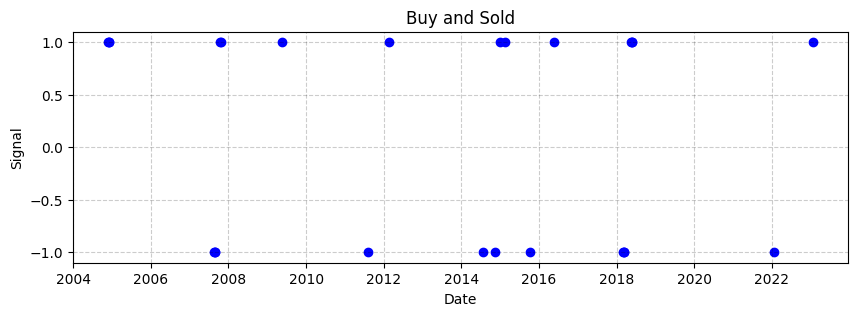

In [10]:
action_dates = [action[5] for action in action_output]
action_signals = [action[1] for action in action_output]
plt.figure(figsize=(10, 3))
plt.scatter(action_dates, action_signals, color='blue')
plt.xlabel('Date')
plt.ylabel('Signal')
plt.title('Buy and Sold')
plt.grid(True, linestyle='--', alpha=0.2, color='black')
plt.show()

In [11]:
action_dates = [mdates.date2num(action[5]) for action in action_output] 
prices = [action[4] for action in action_output]

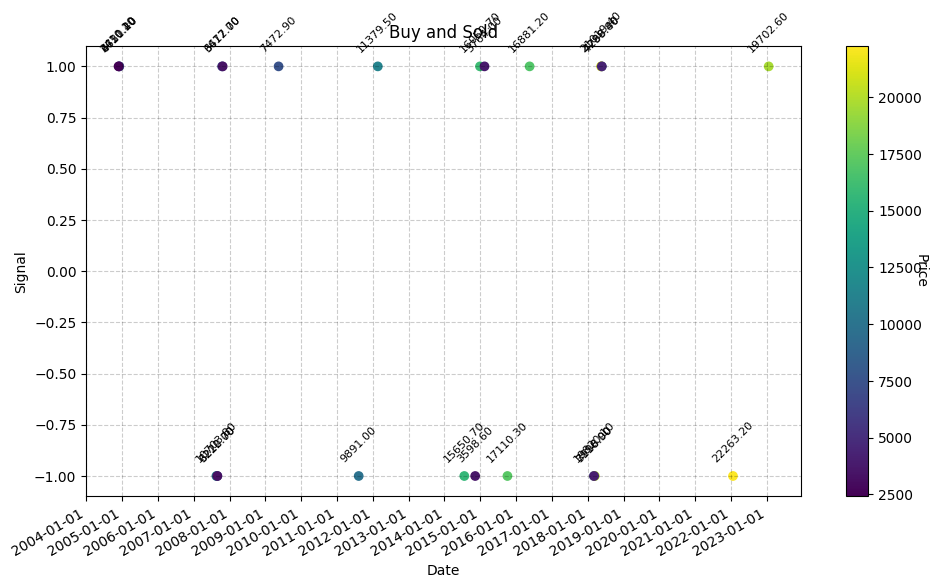

In [12]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(action_dates, action_signals, c=prices, cmap='viridis', marker='o')
plt.xlabel('Date')
plt.ylabel('Signal')
plt.title('Buy and Sold')
cbar = plt.colorbar(sc)
cbar.set_label('Price', rotation=270)  
readable_dates = [mdates.num2date(date).strftime('%Y-%m-%d') for date in action_dates]
for i, (date_num, signal, price) in enumerate(zip(action_dates, action_signals, prices)):
    plt.annotate(
        f'{price:.2f}', 
        (date_num, signal), 
        textcoords="offset points", 
        xytext=(0, 10),  
        ha='center', 
        color='black', 
        fontsize=8, 
        rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()  
plt.grid(True, linestyle='--', alpha=0.2, color='black')
plt.tight_layout()  
plt.show()

In [13]:
#summarized P&L and portfolio values
pnl_summary = pd.DataFrame(index=pd.to_datetime([]))
portfolio_value_summary = pd.DataFrame(index=pd.to_datetime([]))

for ticker, ticker_data in portfolio_data.items():
    dates = pd.to_datetime(ticker_data['dates'])
    pnl_series = pd.Series(ticker_data['pnl_history'], index=dates, name=ticker)
    portfolio_value_series = pd.Series(ticker_data['portfolio_values'], index=dates, name=ticker)
    
    #combine the P&L and portfolio values into the summary 
    pnl_summary = pnl_summary.combine_first(pnl_series.to_frame())
    portfolio_value_summary = portfolio_value_summary.combine_first(portfolio_value_series.to_frame())

#forward fill to handle non-trading days
pnl_summary.ffill(inplace=True)
portfolio_value_summary.ffill(inplace=True)

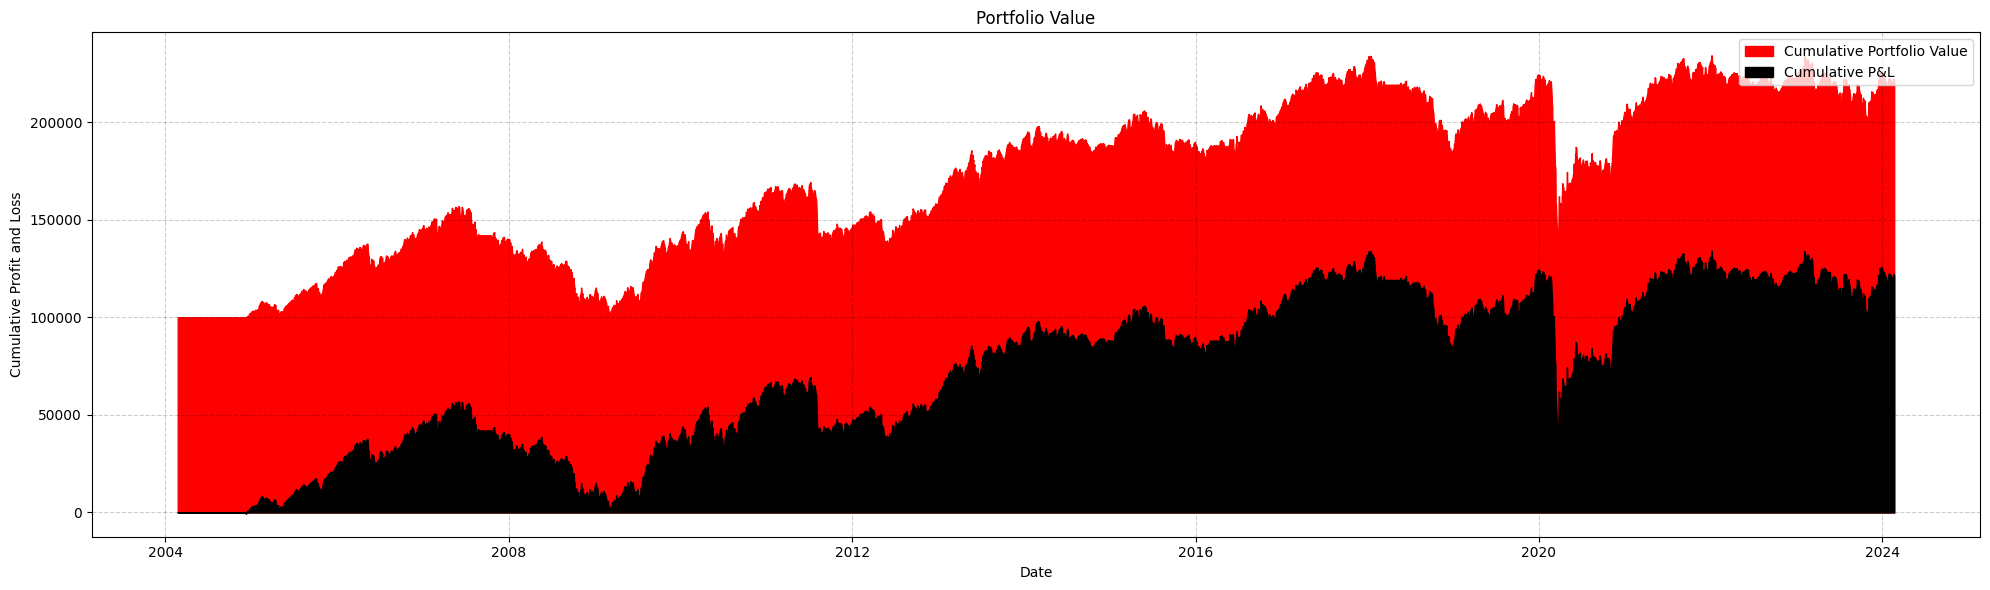

In [14]:
cumulative_pnl = pnl_summary.sum(axis=1)
cumulative_portfolio_value = portfolio_value_summary.sum(axis=1)
plt.figure(figsize=(20, 6))
plt.fill_between(cumulative_portfolio_value.index, cumulative_portfolio_value, label='Cumulative Portfolio Value', linestyle='-',color='red')
plt.fill_between(cumulative_pnl.index, cumulative_pnl, label='Cumulative P&L', color='black', linestyle='-')
plt.title('Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit and Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.2, color='black')
plt.tight_layout()
plt.show()

In [15]:
#overall final portfolio value by summing the last values 
final_portfolio_value = portfolio_value_summary.iloc[-1].sum()
#total profit and loss
total_pnl = final_portfolio_value - total_capital

In [16]:
print(f"Overall Final Portfolio Value: {final_portfolio_value:,.2f}")
print(f"Total Profit and Loss: {total_pnl:,.2f}")

Overall Final Portfolio Value: 221,490.19
Total Profit and Loss: 121,490.19
